#SysRec Baseado em Conteúdo e Filtragem colaborativa- KDnuggets 

https://www.kdnuggets.com/2019/04/building-recommender-system.html


##Geralmente, existem dois tipos de métodos de classificação:
Filtragem baseada em conteúdo , na qual os itens recomendados são baseados na similaridade item a item e nas preferências explícitas do usuário; e
Filtragem colaborativa , na qual os itens são recomendados aos usuários com base nas preferências de outros usuários com históricos de transações e características semelhantes.
As informações usadas na filtragem colaborativa podem ser explícitas, onde os usuários fornecem classificações para cada item, ou implícitas, onde as preferências do usuário devem ser extraídas do comportamento do usuário (compras, visualizações etc.). Os sistemas de recomendação mais bem-sucedidos usam abordagens híbridas que combinam os dois métodos de filtragem.


#Filtragem simples baseada em conteúdo
Vamos construir um sistema de recomendação simples que use filtragem baseada em conteúdo (ou seja, similaridade de itens) para recomendar filmes para assistirmos. Primeiro, carregue o conjunto de dados do filme do MovieLens e faça a codificação múltipla dos campos de gênero:



In [21]:
import pandas as pd
import numpy as np

movies = pd.read_csv("movies.csv")
movies = movies.loc[:25000,:]
# dummy encode the genre
movies = movies.join(movies.genres.str.get_dummies("|"))
movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


O recurso gênero consiste em um ou mais gêneros separados por barras verticais (“|”). A última linha acima adiciona uma coluna para cada gênero possível e coloca 1 nessa entrada se a etiqueta de gênero estiver presente, ou 0 caso contrário.

Vamos gerar algumas recomendações com base na similaridade do item usando essas tags. Uma medida de similaridade muito comum para dados categóricos (como tags) é a similaridade de cosseno . Para quaisquer dois itens eue j, a similaridade do cosseno de eue jé simplesmente o cosseno do ângulo entre eue jonde eue jsão interpretados como vetores no espaço de recursos. Lembre-se de que o cosseno é obtido a partir do produto interno desses vetores:
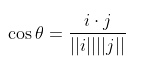 

Como um exemplo concreto, considere os filmes $ i: = $ Toy Story (tags de gênero “Aventura”, “Animação”, “Crianças”, “Comédia” e “Fantasia”) e $ j: = $ Jumanji (tags de gênero “ Aventura ”,“ Crianças ”e“ Fantasia ”). O produto escalar i.j é 3 (os dois filmes têm três marcas em comum), 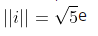 e image.png, portanto, a semelhança de cosseno entre esses dois filmes é: 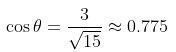

Podemos calcular a semelhança do cosseno para todos os itens em nosso conjunto de dados:

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

# compute the cosine similarity
cos_sim = cosine_similarity(movies.iloc[:,3:])

##O primeiro filme no conjunto de dados é Toy Story. Vamos descobrir quais são os filmes semelhantes a Toy Story:


In [25]:
# Let's get the top 5 most similar films:
toystory_top5 = np.argsort(cos_sim[0])[-5:][::-1]

toystory_top5


array([    0, 20015, 22353,  3021, 12969])

Todos os primeiros cinco filmes têm exatamente as mesmas marcas de gênero que Toy Story e, portanto, uma semelhança de cosseno de 1. Na verdade, para os dados de amostra usados ​​aqui, há treze filmes com semelhança 1; o filme mais semelhante sem tags idênticas é “The Ant Bully” de 2006, que tem a tag de gênero adicional “IMAX”.

#Filtragem Colaborativa Simples
A filtragem colaborativa recomenda itens com base no que usuários semelhantes gostaram. Felizmente, no conjunto de dados MovieLens, temos uma riqueza de informações de preferência do usuário na forma de classificações de filmes: cada usuário atribui a um ou mais filmes classificações numéricas entre 1 e 5, indicando o quanto eles gostaram do filme. Podemos ver o problema de recomendar itens ao usuário como uma tarefa de previsão : dadas as avaliações do usuário de outros filmes, qual é a sua provável avaliação do filme em questão?

Uma maneira simples de fazer isso é atribuir uma classificação ponderada por similaridade a cada item usando as classificações de outros usuários:
![image.png]()

Para nossa medição de similaridade de usuários, veremos as avaliações dos usuários sobre os filmes. Usuários com classificações semelhantes serão considerados semelhantes. Para trabalhar com esses dados de classificação, uma primeira etapa importante é normalizar nossas classificações. Faremos isso em três etapas: primeiro, subtrairemos a classificação média geral (em todos os filmes e usuários) para que nossas classificações ajustadas fiquem centradas em 0. Em seguida, faremos a mesma coisa para cada filme, para conta para as classificações médias de um determinado filme diferente. Finalmente, subtrairemos a classificação média de cada usuário - isso leva em conta as variações individuais (por exemplo, um usuário dando classificações consistentemente mais altas do que outro).
##Vamos carregar os dados de classificações e calcular as classificações ajustadas:

In [16]:
ratings = pd.read_csv("rating.csv")
mean_rating = ratings['rating'].mean() # compute mean rating

pref_matrix1 = ratings[['userId', 'movieId', 'rating']].pivot(index='userId', columns='movieId', values='rating')
pref_matrix2 = pref_matrix1 - mean_rating # adjust by overall mean

item_mean_rating = pref_matrix2.mean(axis=0)
pref_matrix3 = pref_matrix2 - item_mean_rating # adjust by item mean

user_mean_rating = pref_matrix3.mean(axis=1)
pref_matrix = pref_matrix3 - user_mean_rating
pref_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,126245,126405,126426,126560,126927,126959,127088,127096,127110,127166,127196,127212,127222,127224,127302,127319,127323,127881,128488,128510,128594,128601,128622,128648,128686,128715,128832,128842,129030,129233,129235,129303,129354,129428,129707,130052,130073,130219,130490,130642
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,-0.368695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.72271,NaN,NaN,-0.288818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.211838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.072877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.126981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.211182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,-1.174943,NaN,NaN,NaN,0.584002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.144382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.788818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,-0.868695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.642799,NaN,NaN,NaN,NaN,NaN,-1.405106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578159,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5722,0.927123,NaN,NaN,NaN,NaN,-0.174943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.40021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5723,0.927123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.226515,NaN,NaN,-1.144382,NaN,NaN,0.497688,NaN,NaN,0.44167,NaN,NaN,NaN,NaN,NaN,0.750502,NaN,NaN,0.832266,NaN,NaN,NaN,NaN,0.40021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##Neste ponto, podemos estabelecer facilmente uma estimativa de linha de base razoável para a classificação de um determinado usuário de filmes que ele não viu:

In [17]:
pref_matrix.fillna(0) + user_mean_rating + item_mean_rating + mean_rating

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,126245,126405,126426,126560,126927,126959,127088,127096,127110,127166,127196,127212,127222,127224,127302,127319,127323,127881,128488,128510,128594,128601,128622,128648,128686,128715,128832,128842,129030,129233,129235,129303,129354,129428,129707,130052,130073,130219,130490,130642
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.072877,3.500000,3.788162,3.2475,3.754325,4.174943,3.282866,3.700016,2.965788,3.415998,4.357201,2.701754,3.535166,3.523006,2.268187,3.773485,4.405106,3.297764,3.144382,2.746122,3.495536,3.502312,3.51828,3.126981,3.55833,3.639085,3.609761,3.373742,3.50000,3.080911,3.249498,3.500000,2.916732,4.167734,4.285695,3.421841,3.345694,2.753043,3.59979,3.324055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.072877,3.868695,4.000000,3.2475,3.754325,4.174943,3.282866,3.700016,2.965788,3.415998,4.357201,2.701754,3.535166,3.523006,2.268187,3.773485,4.405106,3.297764,3.144382,2.746122,3.495536,3.502312,3.51828,3.126981,3.55833,3.639085,3.609761,3.373742,4.22271,3.080911,3.249498,3.788818,2.916732,4.167734,4.285695,3.421841,3.345694,2.753043,3.59979,3.324055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.000000,3.868695,3.788162,3.2475,3.754325,4.174943,3.282866,3.700016,2.965788,3.415998,4.357201,2.701754,3.535166,3.523006,2.268187,3.773485,4.405106,3.297764,3.144382,2.746122,3.495536,3.502312,3.51828,3.000000,3.55833,3.639085,3.609761,3.373742,4.22271,3.080911,3.249498,4.000000,2.916732,4.167734,4.285695,3.421841,3.345694,2.753043,3.59979,3.324055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.072877,3.868695,3.788162,3.2475,3.754325,3.000000,3.282866,3.700016,2.965788,4.000000,4.357201,2.701754,3.535166,3.523006,2.268187,3.773485,4.405106,3.297764,3.000000,2.746122,3.495536,3.502312,3.51828,3.126981,3.55833,3.639085,3.609761,3.373742,4.22271,3.080911,3.249498,1.000000,2.916732,4.167734,4.285695,3.421841,3.345694,2.753043,3.59979,3.324055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.072877,3.000000,3.788162,3.2475,3.754325,4.174943,3.282866,3.700016,2.965788,3.415998,5.000000,2.701754,3.535166,3.523006,2.268187,3.773485,3.000000,3.297764,3.144382,2.746122,3.495536,3.502312,3.51828,3.126981,3.55833,3.639085,3.609761,3.373742,4.22271,3.080911,3.249498,3.788818,2.916732,4.167734,4.285695,3.421841,3.345694,2.753043,3.59979,3.324055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5721,4.072877,3.868695,3.788162,3.2475,3.754325,4.174943,3.282866,3.700016,2.965788,3.415998,4.357201,2.701754,3.535166,3.523006,2.268187,3.773485,4.405106,3.297764,3.144382,2.746122,3.495536,3.502312,3.51828,3.126981,3.55833,3.639085,3.609761,3.373742,4.22271,3.080911,3.249498,3.788818,2.916732,4.167734,4.285695,4.000000,3.345694,2.753043,3.59979,3.324055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5722,5.000000,3.868695,3.788162,3.2475,3.754325,4.000000,3.282866

##Podemos calcular a distância de um determinado usuário (neste caso, usuário 0) da seguinte maneira:



In [18]:
mat = pref_matrix.values
k = 0 # use the first user
np.nansum((mat - mat[k,:])**2,axis=1).reshape(-1,1)

array([[ 0.  ],
       [13.75],
       [42.25],
       ...,
       [ 4.25],
       [10.  ],
       [51.75]])

##Acontece que o usuário mais próximo é o usuário 12 (com distância 0):





---



In [19]:
np.nansum((mat - mat[0,:])**2,axis=1)[1:].argmin() # returns 11
# check it:
np.nansum(mat[12] - mat[0]) # returns 0.0

6.5

##Encontramos dois filmes que o usuário 12 viu e que o usuário 0 não:



In [20]:
np.where(~np.isnan(mat[12]) & np.isnan(mat[0]) == True)
# returns (array([304, 596]),)

mat[12][[304, 596]]
# returns array([-2.13265214, -0.89476547])

array([       nan, 0.86578573])

##Infelizmente, o usuário 12 não gosta de ambos os filmes que o usuário 0 ainda não viu! Devemos continuar nosso cálculo para contabilizar todos os usuários próximos.

##Observações Finais
Os métodos usados ​​neste post são baseados na vizinhança , e acabamos de ver acima uma armadilha potencial ao gerar recomendações baseadas em vizinhos: os vizinhos podem não recomendar nenhum item que o usuário em questão ainda não tenha visto. Devido à necessidade de calcular distâncias entre pares, os métodos baseados na vizinhança também tendem a ter uma escala insuficiente conforme o número de usuários aumenta.

Na parte 2 desta série, daremos uma olhada em outra abordagem para construir sistemas de recomendação, desta vez usando métodos de fator latente . Os modelos de fator latente evitam algumas das armadilhas dos métodos baseados na vizinhança descritos aqui - mas, como veremos, eles vêm com alguns desafios próprios!